# Statistical Time Series Models

**Ziel:** Klassische statistische Modelle für Zeitreihenvorhersage

**Modelle:**
1. ARIMA - AutoRegressive Integrated Moving Average
2. SARIMA - Seasonal ARIMA
3. SARIMAX - SARIMA mit exogenen Variablen
4. ETS - Exponential Smoothing
5. Auto-ARIMA - Automatische Parameterauswahl

**Basierend auf:** Week02_(S)ARIMA(X) + GARCH

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

from evaluation.metrics import calculate_metrics, print_metrics, compare_models
from visualization.plots import plot_forecast, plot_multiple_forecasts, plot_residuals

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Daten laden

In [2]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test.csv', parse_dates=['timestamp'])

# Index auf timestamp setzen (wichtig für ARIMA)
train_df.set_index('timestamp', inplace=True)
val_df.set_index('timestamp', inplace=True)
test_df.set_index('timestamp', inplace=True)

y_train = train_df['value']
y_test = test_df['value']

print(f"Train: {len(y_train)} | Test: {len(y_test)}")

Train: 18262 | Test: 3914


## 2. Auto-ARIMA für Parameter-Suche

Automatische Bestimmung der optimalen ARIMA-Parameter

In [3]:
print("Starte Auto-ARIMA...\n")
print("⚠️ Dies kann einige Minuten dauern!\n")

# Verwende nur einen Teil der Daten für schnellere Laufzeit
sample_size = min(2000, len(y_train))
y_train_sample = y_train[-sample_size:]

auto_model = auto_arima(
    y_train_sample,
    seasonal=True,
    m=24,  # Saisonalität: 24 Stunden
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_fits=50
)

print("\n" + "="*60)
print("AUTO-ARIMA ERGEBNIS")
print("="*60)
print(auto_model.summary())

# Beste Parameter extrahieren
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"\nBeste Parameter:")
print(f"  ARIMA Order: {best_order}")
print(f"  Seasonal Order: {best_seasonal_order}")

Starte Auto-ARIMA...

⚠️ Dies kann einige Minuten dauern!

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=11.50 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=30163.240, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=29011.840, Time=2.03 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=29121.931, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=30161.240, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=29076.987, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=28981.880, Time=9.25 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=34.85 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=29891.434, Time=6.10 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=28897.254, Time=9.49 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=28919.842, Time=2.31 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=35.40 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept 

## 3. SARIMA Model

Seasonal ARIMA mit den gefundenen Parametern

In [4]:
print("Trainiere SARIMA-Modell...\n")

# Verwende gefundene Parameter oder defaults
sarima_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

print("✅ SARIMA-Modell trainiert")
print(f"\nAIC: {sarima_fit.aic:.2f}")
print(f"BIC: {sarima_fit.bic:.2f}")

Trainiere SARIMA-Modell...



C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ SARIMA-Modell trainiert

AIC: 266412.26
BIC: 266482.56


In [5]:
# Vorhersage
sarima_pred = sarima_fit.forecast(steps=len(y_test))

# Evaluation
sarima_metrics = calculate_metrics(y_test.values, sarima_pred.values, prefix='test_')
print_metrics(sarima_metrics, "SARIMA")

                           SARIMA                           
  test_mae       :    2496.80
  test_rmse      :    3186.03
  test_mape      :      44.94%
  test_smape     :      30.49%
  test_r2        :    -0.2761
  test_mase      :       8.56


## 4. Exponential Smoothing (ETS)

Holt-Winters Methode mit Trend und Saisonalität

In [6]:
print("Trainiere ETS (Exponential Smoothing)...\n")

try:
    ets_model = ExponentialSmoothing(
        y_train,
        seasonal_periods=24,
        trend='add',
        seasonal='add',
        use_boxcox=False
    )
    
    ets_fit = ets_model.fit()
    
    # Vorhersage
    ets_pred = ets_fit.forecast(steps=len(y_test))
    
    # Evaluation
    ets_metrics = calculate_metrics(y_test.values, ets_pred.values, prefix='test_')
    print_metrics(ets_metrics, "ETS (Exponential Smoothing)")
    
except Exception as e:
    print(f"⚠️ ETS fehlgeschlagen: {e}")
    print("Verwende vereinfachte Version...\n")
    
    ets_model = ExponentialSmoothing(
        y_train,
        seasonal_periods=24,
        trend=None,
        seasonal='add'
    )
    
    ets_fit = ets_model.fit()
    ets_pred = ets_fit.forecast(steps=len(y_test))
    ets_metrics = calculate_metrics(y_test.values, ets_pred.values, prefix='test_')
    print_metrics(ets_metrics, "ETS (Simplified)")

Trainiere ETS (Exponential Smoothing)...



C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                ETS (Exponential Smoothing)                 
  test_mae       :  911960.37
  test_rmse      : 1054191.11
  test_mape      :   11688.88%
  test_smape     :     199.07%
  test_r2        : -139709.5643
  test_mase      :    3125.57


## 5. SARIMAX mit exogenen Variablen

Nutze Zeit-Features als zusätzliche Information

In [7]:
# Exogene Variablen: Stunde des Tages, Monat, ist_Wochenende
exog_features = ['hour', 'month', 'is_weekend']

if all(feat in train_df.columns for feat in exog_features):
    print("Trainiere SARIMAX mit exogenen Variablen...\n")
    
    X_train = train_df[exog_features]
    X_test = test_df[exog_features]
    
    sarimax_model = SARIMAX(
        y_train,
        exog=X_train,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    sarimax_fit = sarimax_model.fit(disp=False)
    
    # Vorhersage mit exogenen Variablen
    sarimax_pred = sarimax_fit.forecast(steps=len(y_test), exog=X_test)
    
    sarimax_metrics = calculate_metrics(y_test.values, sarimax_pred.values, prefix='test_')
    print_metrics(sarimax_metrics, "SARIMAX (with exogenous vars)")
else:
    print("⚠️ Exogene Features nicht verfügbar, überspringe SARIMAX")
    sarimax_pred = None
    sarimax_metrics = None

Trainiere SARIMAX mit exogenen Variablen...



C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


               SARIMAX (with exogenous vars)                
  test_mae       :    9960.90
  test_rmse      :   10782.06
  test_mape      :     146.04%
  test_smape     :      74.07%
  test_r2        :   -13.6148
  test_mase      :      34.14


## 6. Modell-Vergleich

In [8]:
all_results = {
    'SARIMA': sarima_metrics,
    'ETS': ets_metrics
}

if sarimax_metrics is not None:
    all_results['SARIMAX'] = sarimax_metrics

comparison_df = compare_models(all_results, sort_by='test_rmse')

print("\n" + "=" * 80)
print("STATISTICAL MODELS - COMPARISON")
print("=" * 80)
display(comparison_df.round(2))

best_model = comparison_df['test_rmse'].idxmin()
print(f"\n🏆 Best Model: {best_model}")


STATISTICAL MODELS - COMPARISON


,test_mae,test_rmse,test_mape,test_smape,test_r2,test_mase
SARIMA,2496.80,3186.03,44.94,30.49,-0.28,8.56
SARIMAX,9960.90,10782.06,146.04,74.07,-13.61,34.14
ETS,911960.37,1054191.11,11688.88,199.07,-139709.56,3125.57



🏆 Best Model: SARIMA


## 7. Visualisierung

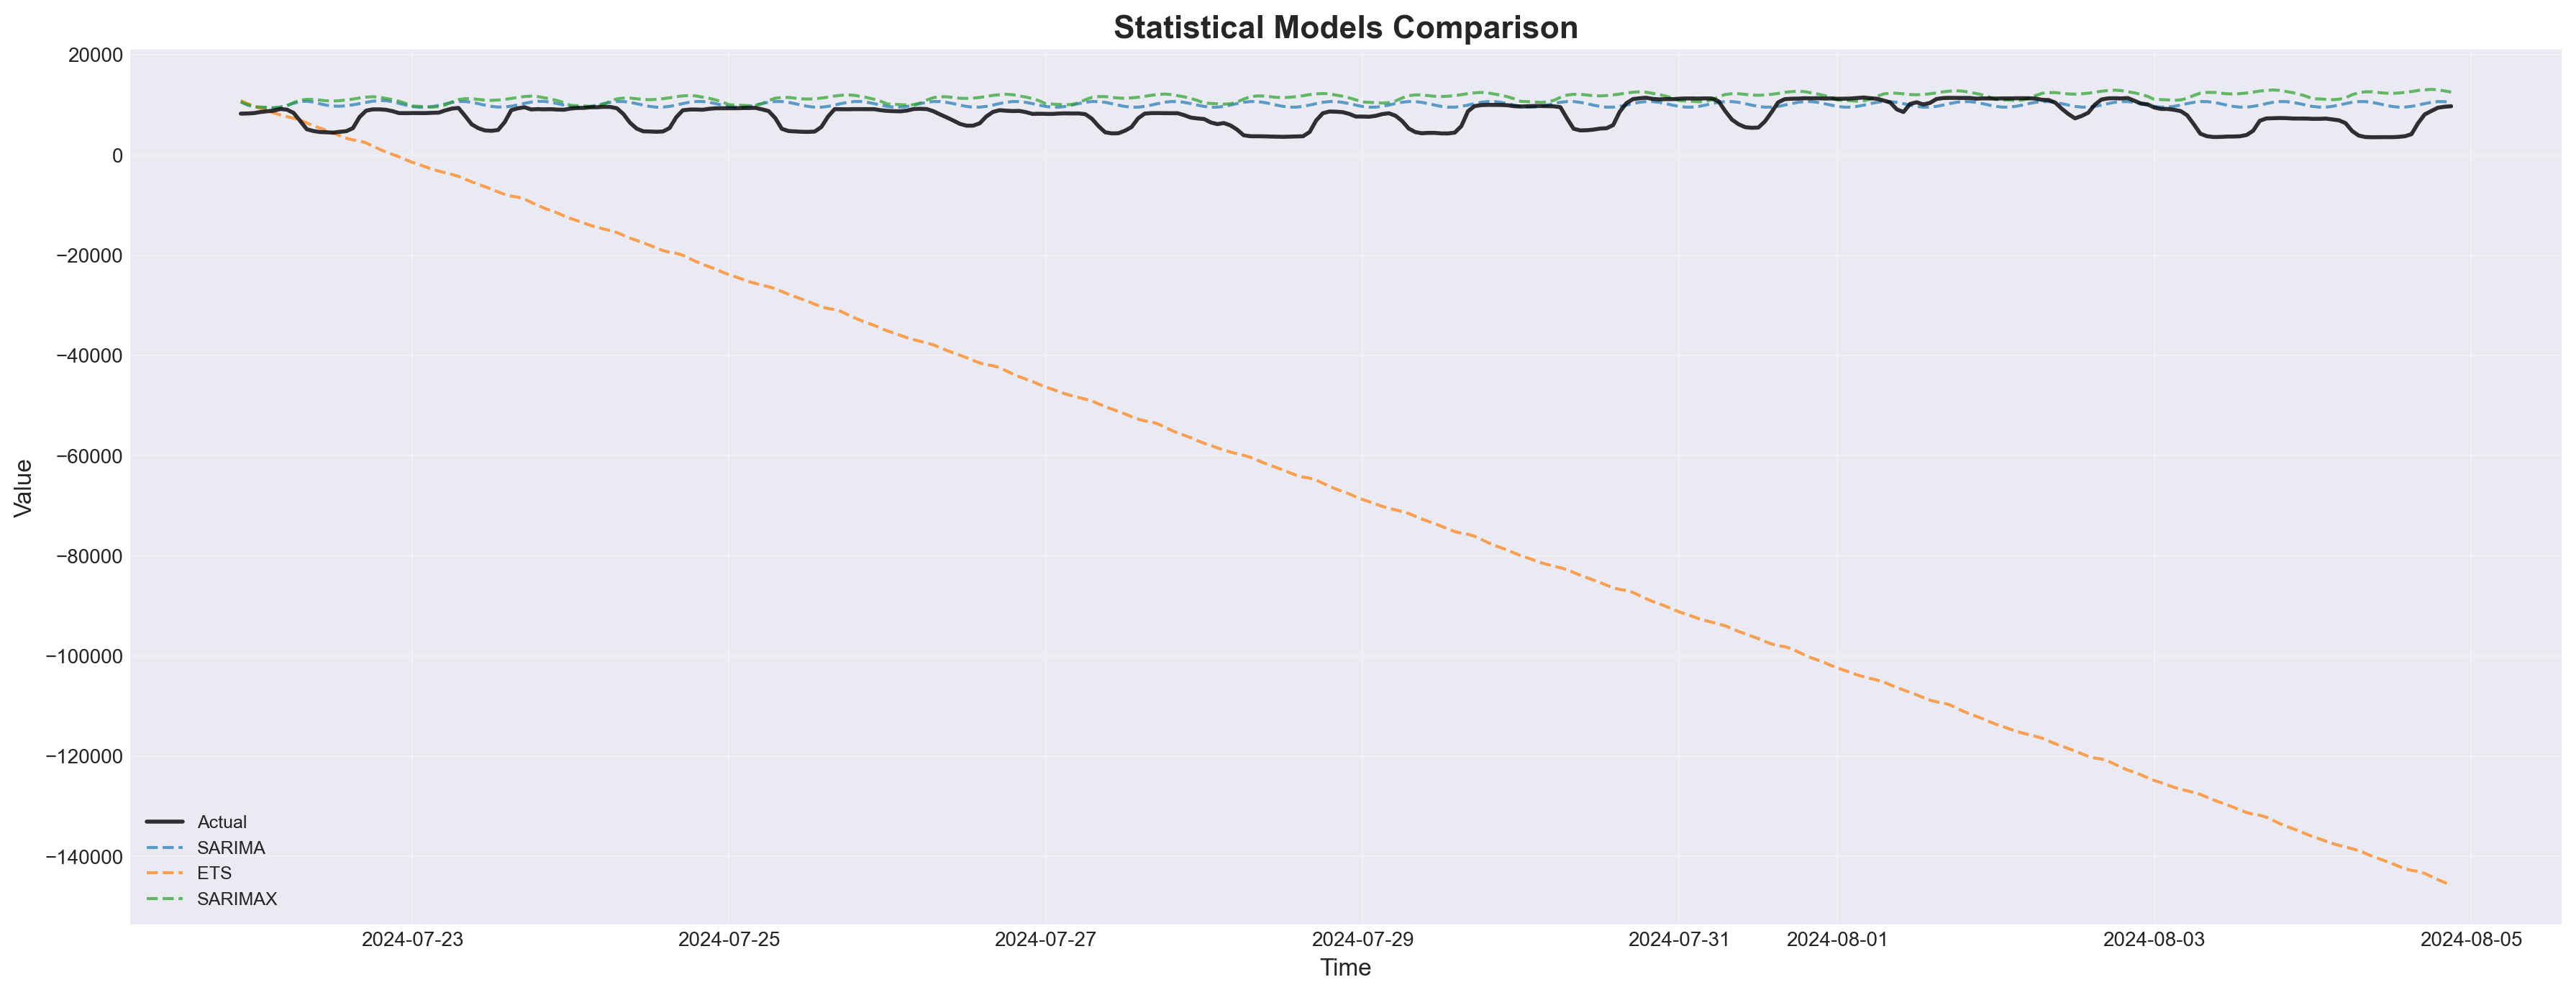

In [9]:
plot_window = 168 * 2  # 2 Wochen

forecasts = {
    'SARIMA': sarima_pred.values[:plot_window],
    'ETS': ets_pred.values[:plot_window]
}

if sarimax_pred is not None:
    forecasts['SARIMAX'] = sarimax_pred.values[:plot_window]

plot_multiple_forecasts(
    y_test.index[:plot_window],
    y_test.values[:plot_window],
    forecasts,
    title="Statistical Models Comparison",
    figsize=(18, 7)
)

## 8. Residual-Analyse

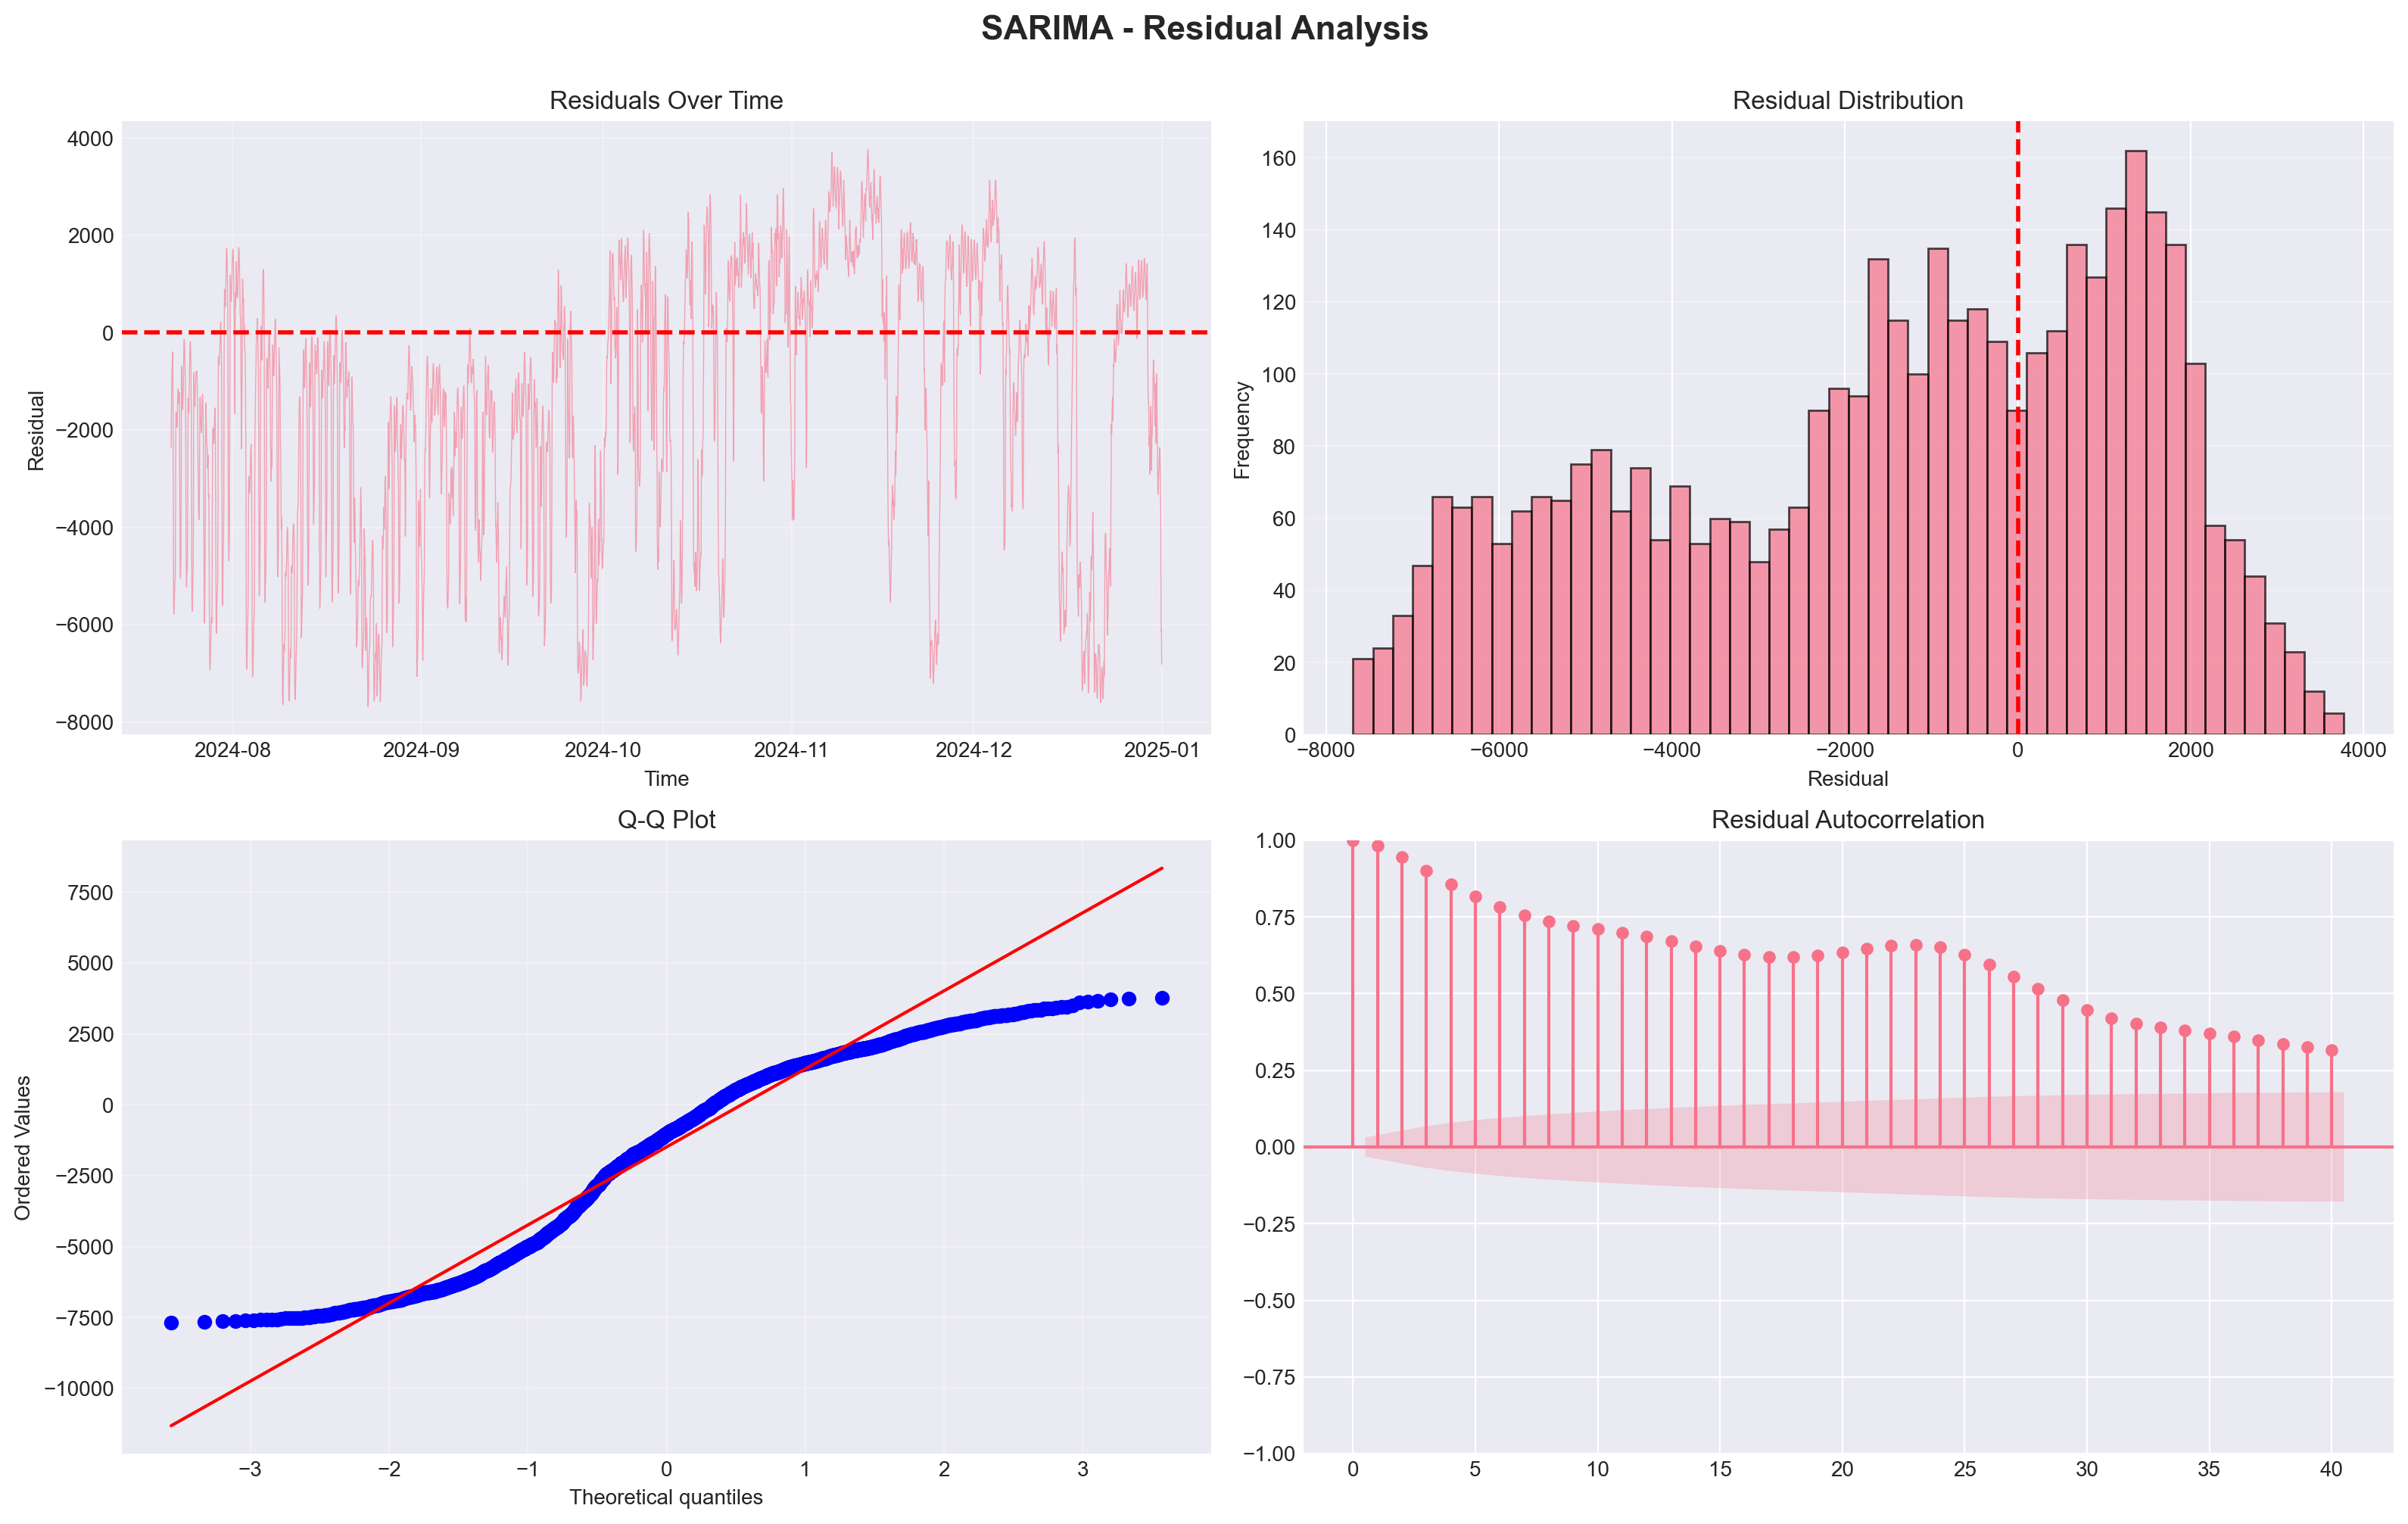

In [10]:
# SARIMA Residuen
sarima_residuals = y_test.values - sarima_pred.values

plot_residuals(
    sarima_residuals,
    timestamps=y_test.index,
    model_name="SARIMA",
    figsize=(16, 10)
)

## 9. Ergebnisse speichern

In [11]:
results_dir = Path('../results/metrics')
results_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(results_dir / f'{DATA_TYPE}_statistical_results.csv')
print(f"✅ Ergebnisse gespeichert")

✅ Ergebnisse gespeichert


## 10. Zusammenfassung

### Erkenntnisse:

1. **SARIMA** berücksichtigt sowohl Trend als auch Saisonalität
2. **SARIMAX** kann zusätzliche Features (Wetter, Feiertage) nutzen
3. **ETS** ist oft schneller zu trainieren

### Nächste Schritte:

**Machine Learning Models** → `05_ml_tree_models.ipynb`
- XGBoost, LightGBM, CatBoost
- Können komplexe nicht-lineare Muster lernen